In [230]:
import random
import matplotlib.pyplot as plt

In [231]:
# Key Encoding:
# Total-AceAs11-Action
# (Total of Cards)-(0:No, 1:Yes)-(0:Stand, 1:Hit)

# Dict Value:
# [Counts, Probability]
class stateActionVal:
    def __init__(self):
        self.counts = {}
        for total in range(12, 21):
            key = str(total) + '-0-0'
            self.counts[key] = [0, 0]
            key = str(total) + '-0-1'
            self.counts[key] = [0, 0]
            key = str(total) + '-1-0'
            self.counts[key] = [0, 0]
            key = str(total) + '-1-1'
            self.counts[key] = [0, 0]

    def incCount(self, key):
        self.counts[key][0] += 1

    def updProb(self, key, outcome):
        self.counts[key][1] += outcome 
    
    def printDict(self):
        for key, val in self.counts.items():
            print("Key: ", key ,", Iterations: ",  val[0], ", Prob: ", val[1])

In [232]:
class player:
    def __init__(self):
        self.cards = [] # cards currently in hand
        self.total = 0 # card total
        self.hasAce = False # True if an ace is being used as a 11
    
    def addCard(self, card):
        self.cards.append(card)
        if(card.rank == "J" or card.rank == "Q" or card.rank == "K"):
            self.total += 10
        elif(card.rank == "A" and self.hasAce == False):
            self.total += 11
            self.hasAce = True
        else:
            if card.rank == 'A' and self.hasAce: # you can not have 2 aces as 11, as that would make a total of 22
                self.total += 1 # use the ace as a one
            else:
                self.total += int(card.rank)
        
        if self.total > 21 and self.hasAce == True:
            self.hasAce = False
            self.total -= 10 # 11 - 10 = 1
    
    def hit(self, myDeck):
        self.addCard(myDeck.getRandomCard())
    
    
    def clear(self):
        self.cards = []
        self.total = 0
        self.hasAce = False

In [233]:
class card:
    def __init__(self, suit, rank):
        self.suit = suit # ♧, ♢, ♥, ♤
        self.rank = rank # 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q, K, A

In [234]:
class deck:
    def __init__(self):
        self.cards = []
        self.setDeck()
        
    def setDeck(self):
        self.cards = []
        suits = ["♧", "♢", "♥", "♤"]
        ranks = [2, 3, 4, 5, 6, 7, 8, 9, 10, "J", "Q", "K", "A"]

        for suit in suits:
            for rank in ranks:
                self.cards.append(card(suit, rank))  # init deck
    
    def printDeck(self):
        for card in self.cards:
            print(card.rank, card.suit)
    
    def shuffle(self):
        random.shuffle(self.cards) # change card order

    def getRandomCard(self):
        temp = self.cards[0]
        del self.cards[0] # delete a card form the deck
        return temp

In [235]:
class blackJackRound:
    def __init__(self, deck, player, dealer):
        self.player = player
        self.dealer = dealer
        self.deck = deck
        self.newRound()
        
    
    def newRound(self):
        self.player.clear() # init found
        self.dealer.clear()
        self.deck.setDeck()
        self.deck.shuffle()
        self.hitPlayerBool = True

        self.player.hit(self.deck) # give player 2 cards
        self.player.hit(self.deck)
        self.dealer.hit(self.deck) # give dealer 1 card
    
    def hitDealer(self):
        if(self.player.total <= 21): # dealer will only hit if player is not bust
            while(self.dealer.total < 17): # dealer will always hit till his total is greather than 17
                self.dealer.hit(self.deck)
    
    def hitPlayer(self):
        while(self.hitPlayerBool):
            if(self.player.total == 21):
                self.hitPlayerBool = False
            elif(self.player.total < 12):
                #Ai go hererererere
                self.player.hit(self.deck)
            else:
                self.hitPlayerBool = False
    
    def outcome(self): # print outcome
        print("Player: ", self.player.total)
        print("Dealer: ", self.dealer.total)

        if(self.player.total <= 21 and (self.player.total > self.dealer.total or self.dealer.total > 21)): # player wins
            print("Player wins")
        elif(self.player.total == self.dealer.total): # player and dealer same total
            print("Draw")
        else:
            print("Dealer wins")
    
    def playRound(self): # play full round
        self.newRound()
        self.hitPlayer()
        self.hitDealer()
        self.outcome()

In [236]:
class monteCarloControl:
    def __init__(self):
        self.tracker = stateActionVal()

    def exec(self, numLoop):
        for k in range((numLoop + 1)):
            continue

In [237]:
class SARSA:
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []
    
    def training(self, numOfEps):
        discountFactor = 1
        dealer = player()
        p = player()
        d = deck()
        b = blackJackRound(d, p, dealer)

        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0
    
        for k in range(1, numOfEps):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            e = 1/k
            while b.player.total < 12:
                b.player.hit(b.deck)
            
            if b.player.total != 21:
                sa = epsilonGreedy([b.player.total, b.player.hasAce], e, self.stateActionVal)
                learningFactor = 1/(self.stateActionVal.counts[sa][0] + 1)

            while b.player.total < 21:
                # Execute action an state s
                if sa[-1] == 1:
                    b.player.hit()
                else:
                    self.stateActionVal.counts[sa][0] += 1
                    break
                
                # Get reward n form s`
                if b.player.total < 22:
                    n = 10 - (21 - b.player.total)
                    # Get next action a`
                    a = epsilonGreedy([b.player.total, b.player.hasAce], e, self.stateActionVal)

                     # Get Q(s`, a`) from table
                    saPrime = self.stateActionVal[a][1] # 0
                
                    # update
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + learningFactor*(n + discountFactor*saPrime - self.stateActionVal.counts[sa][1])
                else:
                    self.stateActionVal.counts[sa][1] -= 1

                #seting new sa
                sa = saPrime
            
            b.hitDealer()
            #b.outcome()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                self.stateActionVal.counts[sa][1] += 1
                countWins[count1000] += 1
            elif(b.player.total == b.dealer.total):
                self.stateActionVal.counts[sa][1] += 0
                countDraw[count1000] += 1
            elif(b.player.total <= 21):
                self.stateActionVal.counts[sa][1] -= 1
                countLose[count1000] += 1

        self.counts = [countWins, countDraw, countLose]

    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])




In [238]:
def epsilonGreedy(state, epsilonVal, stateAcVal): #state will be and array [total, hasAce]
        s1 = str(state[0])+"-"+str(int(state[1]))+"-0"
        s2 = str(state[0])+"-"+str(int(state[1]))+"-1"
        a1 = stateAcVal.counts[s1]
        a2 = stateAcVal.counts[s2]

        if a1[1] < a2[1]:
            worseOption = s1
            bestOption = s2
        else:
            worseOption = s2
            bestOption = s1

        if random.uniform(0, 1) < epsilonVal:
            return worseOption
        else:
            return bestOption

In [239]:
sarse = SARSA()

numOfEps = 500000

sarse.training(numOfEps)


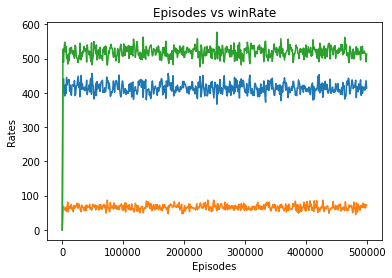

In [240]:
episodes = []
for x in range(int(numOfEps/1000) + 1):
    episodes.append(x*1000)

wins = [0]
draws = [0]
losses = [0]
for x in sarse.counts[0]:
    wins.append(x)
for x in sarse.counts[1]:
    draws.append(x)
for x in sarse.counts[2]:
    losses.append(x)

plt.plot(episodes, wins) # wins
plt.plot(episodes, draws) # draws
plt.plot(episodes, losses) # losses
plt.title('Episodes vs winRate')
plt.xlabel('Episodes')
plt.ylabel('Rates')
plt.show()

In [241]:
sarse.stateActionVal.printDict()

Key:  12-0-0 , Iterations:  26698 , Prob:  -9833
Key:  12-0-1 , Iterations:  26660 , Prob:  -9833
Key:  12-1-0 , Iterations:  1250 , Prob:  -329
Key:  12-1-1 , Iterations:  934 , Prob:  -326
Key:  13-0-0 , Iterations:  25436 , Prob:  -9508
Key:  13-0-1 , Iterations:  25685 , Prob:  -9506
Key:  13-1-0 , Iterations:  3129 , Prob:  -1042
Key:  13-1-1 , Iterations:  2940 , Prob:  -1044
Key:  14-0-0 , Iterations:  23932 , Prob:  -8809
Key:  14-0-1 , Iterations:  24165 , Prob:  -8807
Key:  14-1-0 , Iterations:  3148 , Prob:  -1043
Key:  14-1-1 , Iterations:  2878 , Prob:  -1043
Key:  15-0-0 , Iterations:  23171 , Prob:  -8751
Key:  15-0-1 , Iterations:  22950 , Prob:  -8752
Key:  15-1-0 , Iterations:  3002 , Prob:  -1124
Key:  15-1-1 , Iterations:  3199 , Prob:  -1123
Key:  16-0-0 , Iterations:  20825 , Prob:  -8181
Key:  16-0-1 , Iterations:  21909 , Prob:  -8179
Key:  16-1-0 , Iterations:  3447 , Prob:  -1126
Key:  16-1-1 , Iterations:  2950 , Prob:  -1125
Key:  17-0-0 , Iterations:  19895